In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import torch
from torch.utils.data import DataLoader
import IPython.display as ipd

from src.data import AudioTestDataset, postprocess, zero_pad
from src.models import AIGCNN
from src.utils import STFT, iSTFT
from src.algorithms import GLA, DeGLI

In [18]:
def play_sound(data, rate):
    return ipd.Audio(data, rate=rate)

def plot_spectrogram(c):
    plt.figure(figsize=(5,8))
    plt.imshow(torch.log((c)**2 +1e-10), origin='lower')

# Config

In [19]:
SAMPLING_RATE = 22050
WINLEN = 1024
NFFT  = 1024
SHIFT = 256

NUM_CH = 32
BATCH_SIZE = 8

stft  = STFT(WINLEN, SHIFT, NFFT)
istft = iSTFT(WINLEN, SHIFT, NFFT)

# Data

In [4]:
data_folder = '../data/'
test_files = [os.path.join(data_folder, 'test', name) for name in os.listdir(os.path.join(data_folder, 'test'))]

test_dataset = AudioTestDataset(test_files, stft, WINLEN, SHIFT)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

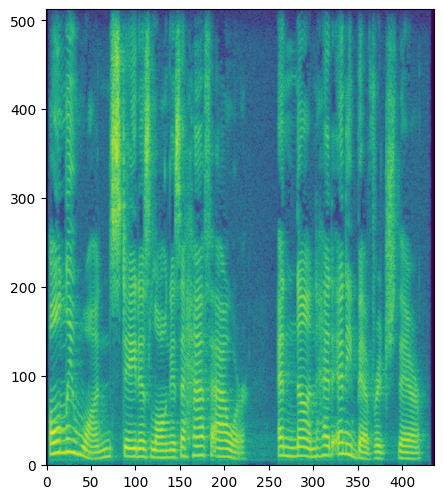

In [5]:
(X, amp, len_x) = test_dataset[0]
# Spectrogram
plot_spectrogram(amp)

### Original audio

In [6]:
# Audio signal
x = istft(X)
x = postprocess(x, len_x, WINLEN, SHIFT)
sf.write('sounds/original.wav', x[:56000], SAMPLING_RATE)
play_sound(x[:56000], SAMPLING_RATE)

### Random phase

In [7]:
# Amplitude with random phase
random_phase = torch.rand(amp.size())*2*torch.pi - torch.pi
X_0 = amp * torch.exp(1j*random_phase)

x_randomphase = istft(X_0)
x_randomphase = postprocess(x_randomphase, len_x, WINLEN, SHIFT)
sf.write('sounds/random_phase.wav', x_randomphase[:56000], SAMPLING_RATE)
play_sound(x_randomphase[:56000], SAMPLING_RATE)

### Zero phase

In [8]:
# Amplitude with zero phase
zero_phase = torch.zeros(amp.size())
X_0 = amp * torch.exp(1j*zero_phase)

x_zerophase = istft(X_0)
x_zerophase = postprocess(x_zerophase, len_x, WINLEN, SHIFT)
sf.write('sounds/zero_phase.wav', x_zerophase[:56000], SAMPLING_RATE)
play_sound(x_zerophase[:56000], SAMPLING_RATE)

# GLA: Griffin-Lim algorithm for Phase Reconstruction

```python
def GLA(amp, n_iter, stft, istft):
    # Random phase initialization
    random_phase = torch.rand(amp.size())*2*torch.pi - torch.pi
    X_0 = amp * torch.exp(1j*random_phase)

    # GLA iterations
    X = X_0
    for i in range(n_iter):
        Y = amp * torch.sgn(X)
        Z = stft(istft(Y))
        X = Z

    # Final projection
    X = amp * torch.sgn(X)
    return X
```

In [9]:
# Number of iterations
M_ITERATIONS = 100

# Sample
X_gt, amp, len_x = test_dataset[0]

# GLA
X = GLA(amp, M_ITERATIONS, stft, istft)

x_gla = istft(X)
x_gla = postprocess(x_gla, len_x, WINLEN, SHIFT)
sf.write('sounds/gla.wav', x_gla[:56000], SAMPLING_RATE)
play_sound(x_gla[:56000], SAMPLING_RATE)

# DeGLI: Deep Griﬃn–Lim Iteration

```python
def DeGLI(amp, model, n_iter, stft, istft):
    # Random phase initialization
    random_phase = torch.rand(amp.size())*2*torch.pi - torch.pi
    X_0 = amp * torch.exp(1j*random_phase)

    X = X_0.unsqueeze(0)
    amp_batch = amp.unsqueeze(0)

    # DeGLI iterations
    for i in range(n_iter):
        Y = amp_batch * torch.sgn(X)
        Z = stft(istft(Y))

        X_re = torch.real(X).unsqueeze(1)
        X_im = torch.imag(X).unsqueeze(1)
        Y_re = torch.real(Y).unsqueeze(1)
        Y_im = torch.imag(Y).unsqueeze(1)
        Z_re = torch.real(Z).unsqueeze(1)
        Z_im = torch.imag(Z).unsqueeze(1)
        feat_conc_re  = torch.cat([X_re, Y_re, Z_re], dim=1)
        feat_conc_im  = torch.cat([X_im, Y_im, Z_im], dim=1)

        with torch.no_grad():
            out_dnn = model(feat_conc_re, feat_conc_im, amp_batch)
            X = Z - out_dnn

    # Final projection
    X = amp * torch.sgn(X.squeeze())
    return X
```

In [10]:
# Model and load pre-trained checkpoint
DNN = AIGCNN(NUM_CH, kernel_size=(3,5))
DNN.load_state_dict(torch.load('checkpoints/degli_ljspeech.pth'))
DNN.eval()

# Number of iterations
M_ITERATIONS = 10

# Sample
X_gt, amp, len_x = test_dataset[0]

# DeGLI
X = DeGLI(amp, DNN, M_ITERATIONS, stft, istft)

x_degli = istft(X)
x_degli = postprocess(x_degli, len_x, WINLEN, SHIFT)
sf.write('sounds/degli.wav', x_degli[:56000], SAMPLING_RATE)
play_sound(x_degli[:56000], SAMPLING_RATE)

# New audio file

In [21]:
file = 'sounds/test/mix.wav'
output_dir = 'sounds/test/'

data, _ = sf.read(file)
# If multiple channels
if len(data.shape) > 1:
    data = data.sum(1)
# Prepare data
data /= np.max(np.abs(data))
len_x = len(data)
data = np.concatenate((np.zeros(WINLEN-SHIFT,), data, np.zeros(WINLEN-SHIFT,)), axis=0)
data = zero_pad(data, WINLEN, SHIFT)
x = torch.FloatTensor(data)

# Get spectrogram and amplitude
X = stft(x)
amp = torch.abs(X)

# Play prepared sound
x = istft(X)
x = postprocess(x, len_x, WINLEN, SHIFT)
sf.write(output_dir + 'original.wav', x, SAMPLING_RATE)
play_sound(x, SAMPLING_RATE)

In [22]:
# Amplitude with random phase
random_phase = torch.rand(amp.size())*2*torch.pi - torch.pi
X_0 = amp * torch.exp(1j*random_phase)

x_randomphase = istft(X_0)
x_randomphase = postprocess(x_randomphase, len_x, WINLEN, SHIFT)
sf.write(output_dir + 'random_phase.wav', x_randomphase, SAMPLING_RATE)
play_sound(x_randomphase, SAMPLING_RATE)

In [23]:
# Amplitude with zero phase
zero_phase = torch.zeros(amp.size())
X_0 = amp * torch.exp(1j*zero_phase)

x_zerophase = istft(X_0)
x_zerophase = postprocess(x_zerophase, len_x, WINLEN, SHIFT)
sf.write(output_dir + 'zero_phase.wav', x_zerophase, SAMPLING_RATE)
play_sound(x_zerophase, SAMPLING_RATE)

### GLA

In [24]:
# Number of iterations
M_ITERATIONS = 100

# GLA
X = GLA(amp, M_ITERATIONS, stft, istft)

x_gla = istft(X)
x_gla = postprocess(x_gla, len_x, WINLEN, SHIFT)
sf.write(output_dir + 'gla.wav', x_gla, SAMPLING_RATE)
play_sound(x_gla, SAMPLING_RATE)

### DeGLI

In [25]:
# Model and load pre-trained checkpoint
DNN = AIGCNN(NUM_CH, kernel_size=(3,5))
DNN.load_state_dict(torch.load('checkpoints/degli_ljspeech.pth'))
DNN.eval()

# Number of iterations
M_ITERATIONS = 10

# DeGLI
X = DeGLI(amp, DNN, M_ITERATIONS, stft, istft)

x_degli = istft(X)
x_degli = postprocess(x_degli, len_x, WINLEN, SHIFT)
sf.write(output_dir + 'degli.wav', x_degli, SAMPLING_RATE)
play_sound(x_degli, SAMPLING_RATE)